<a href="https://colab.research.google.com/github/wangyeye66/projects/blob/main/Document_Clustering_and_Topic_Modeling_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document Clustering and Topic Modeling

*In* this project, we use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

## Contents

* [Part 1: Load Data](#Part-1:-Load-Data)
* [Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
* [Part 3: TF-IDF](#Part-3:-TF-IDF)
* [Part 4: K-means clustering](#Part-4:-K-means-clustering)
* [Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)


# Part 0: Setup Google Drive Environment

In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
file = drive.CreateFile({'id':'192JMR7SIqoa14vrs7Z9BXO3iK89pimJL'}) # replace the id with id of file you want to access
file.GetContentFile('data.tsv')  # tab-separated

# Part 1: Load Data

In [3]:
import numpy as np
import pandas as pd
import nltk
# import gensim

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
# Load data into dataframe
df = pd.read_csv('data.tsv', sep='\t', on_bad_lines='skip')

In [32]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [6]:
# Handling missing value
print(f"Before droping na: {df['review_body'].isna().sum()}")
df.dropna(subset=['review_body'],inplace=True)
print(f"After droping na: {df['review_body'].isna().sum()}")
df.shape

Before droping na: 148
After droping na: 0


(960056, 15)

In [33]:
# len = 960056
data = df[:1000]['review_body'].to_list()
len(data)

1000

# Part 2: Data  Cleaning, Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [83]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

custom_stop_words = ['br','watch, "n't",''s']
for word in custom_stop_words:
    stopwords.append(word)

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

SyntaxError: unterminated string literal (detected at line 4) (<ipython-input-83-5e4d2f7f7db0>, line 4)

In [50]:
%%capture
! pip install transformers
! pip install nltk pandas spellchecker emoji
! pip install pyspellchecker

In [66]:
# Define cleaning function
nltk.download('wordnet')
nltk.download('punkt')

import re
import emoji
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

spell = SpellChecker()
lemmatizer = WordNetLemmatizer()

def remove_urls(text):
  return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_emails(text):
  return re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

def remove_punctuations(text):
  text = re.sub(r'<[^>]+>', '', text)
  return re.sub(r'[^\w\s]', '', text)

def remove_emojis(text):
  return emoji.replace_emoji(text, replace='')

def remove_phone_numbers(text):
  pattern = r'\b(?:\+?(\d{1,3}))?[-. (]*(\d{3})[-. )]*(\d{3})[-. ]*(\d{4,})\b'
  return re.sub(pattern, '', text)

def spell_check_tokens(tokens):
  return [spell.correction(token) for token in tokens]

# tokenize first, then check spelling, then lemmatize
def tokenize_remove_stopwords_lemmatize_and_spell_check(text):
  text = text.lower()
  tokens = nltk.word_tokenize(text)
  # corrected_tokens = spell_check_tokens(tokens)
  lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word]
  return [word for word in lemmatized_tokens if word not in stopwords]

def clean_texts(text_list):
  cleaned_texts = []
  for text in text_list:
    if not isinstance(text, str):
      print(f"Skipping non-string item: {text}")
      continue
    text = remove_urls(text)
    text = remove_emails(text)
    text = remove_phone_numbers(text)
    text = remove_punctuations(text)
    text = remove_emojis(text)
    tokens = tokenize_remove_stopwords_lemmatize_and_spell_check(text)
    cleaned_text = ' '.join(tokens)  # Join tokens back to a single string
    cleaned_texts.append(cleaned_text)
  return cleaned_texts


data_cleaned = clean_texts(data)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Skipping non-string item: nan


In [68]:
# There is a non-string item in our list, let's drop it
non_string_indices = [index for index, item in enumerate(data) if not isinstance(item, str)]

print("Indices of items that are not strings:", non_string_indices)

my_list = data[:964] + data[965:]


Indices of items that are not strings: [964]


In [69]:
non_string_indices = [index for index, item in enumerate(my_list) if not isinstance(item, str)]

print("Indices of items that are not strings:", non_string_indices)

Indices of items that are not strings: []


In [70]:
print(f'{data[0]} \n  changed to \n {data_cleaned[0]}')

Absolutely love this watch! Get compliments almost every time I wear it. Dainty. 
  changed to 
 absolutely love get compliment almost every time wear dainty


# Part 3: TF-IDF

TF: Term Frequency

IDF: Inverse Document Frequency

Costom Tonkenizer

In [95]:
from nltk.stem import PorterStemmer

def tokenization_and_stemming(text):
    tokens = []
    stemmer=nltk.PorterStemmer()
    # exclude stop words and tokenize the document, generate a list of string
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []

    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)

    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer

# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words in the dictionary
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df = 0.99, max_features=1000,
                                 min_df = 0.01, stop_words='english',
                                 use_idf = True, tokenizer = tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data_cleaned) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'where

In total, there are 999 reviews and 250 terms.


Save the terms identified by TF-IDF.

In [143]:
# words
tf_selected_words_costom = tfidf_model.get_feature_names_out()

In [144]:
# print out words
tf_selected_words_costom

array(['abl', 'absolut', 'accur', 'actual', 'adjust', 'alarm', 'alreadi',
       'alway', 'amaz', 'amazon', 'anoth', 'arm', 'arriv', 'automat',
       'awesom', 'bad', 'band', 'batteri', 'beauti', 'best', 'better',
       'big', 'bit', 'black', 'blue', 'bought', 'box', 'bracelet',
       'brand', 'break', 'bright', 'broke', 'button', 'buy', 'came',
       'case', 'casio', 'chang', 'cheap', 'classi', 'clock', 'color',
       'come', 'comfort', 'compliment', 'cool', 'cost', 'crown',
       'crystal', 'dark', 'date', 'daughter', 'day', 'deal', 'definit',
       'deliveri', 'design', 'dial', 'didnt', 'differ', 'difficult',
       'disappoint', 'display', 'doe', 'doesnt', 'dont', 'dress',
       'durabl', 'easi', 'easili', 'end', 'everi', 'everyday', 'everyth',
       'exactli', 'excel', 'expect', 'expens', 'face', 'far', 'fast',
       'featur', 'feel', 'fell', 'fine', 'finish', 'fit', 'function',
       'gave', 'gift', 'gold', 'good', 'got', 'great', 'ha', 'hand',
       'happi', 'hard', 

gensim_tokenizer

In [145]:
from gensim.utils import simple_preprocess

def gensim_tokenizer(text):
    return simple_preprocess(text, deacc=True)

tfidf_model = TfidfVectorizer(max_df = 0.99, max_features=1000,
                              min_df = 0.01, stop_words='english',
                              use_idf = True, tokenizer = gensim_tokenizer, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(my_list) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 999 reviews and 244 terms.


In [146]:
tf_selected_words_gensim = tfidf_model.get_feature_names_out()
tf_selected_words_gensim

array(['able', 'absolutely', 'actually', 'alarm', 'amazing', 'amazon',
       'arrived', 'automatic', 'awesome', 'bad', 'band', 'battery',
       'beautiful', 'best', 'better', 'big', 'bit', 'black', 'blue',
       'bought', 'box', 'br', 'bracelet', 'bright', 'broke', 'buy',
       'buying', 'came', 'case', 'casio', 'change', 'cheap', 'clasp',
       'classy', 'clock', 'color', 'colors', 'come', 'comfortable',
       'compliments', 'cool', 'cost', 'crown', 'crystal', 'dark', 'date',
       'daughter', 'day', 'days', 'deal', 'definitely', 'delivery',
       'design', 'dial', 'did', 'didn', 'different', 'difficult',
       'disappointed', 'display', 'does', 'doesn', 'don', 'dress',
       'durable', 'easily', 'easy', 'end', 'everyday', 'exactly',
       'excellent', 'expected', 'expensive', 'face', 'far', 'fast',
       'features', 'feel', 'feels', 'fell', 'fine', 'finish', 'fit',
       'fits', 'functional', 'gave', 'getting', 'gift', 'going', 'gold',
       'good', 'got', 'great', 'han

In [147]:
common_terms = set(tf_selected_words_costom).intersection(set(tf_selected_words_gensim))
print(f"{len(common_terms)} common terms: {common_terms}")


140 common terms: {'bracelet', 'money', 'like', 'use', 'son', 'fit', 'box', 'star', 'display', 'dial', 'hard', 'feel', 'crystal', 'month', 'lot', 'worn', 'seller', 'worth', 'great', 'model', 'right', 'bought', 'recommend', 'buy', 'bit', 'know', 'stylish', 'week', 'end', 'movement', 'point', 'new', 'band', 'second', 'person', 'better', 'best', 'product', 'red', 'real', 'night', 'wear', 'kept', 'paid', 'low', 'say', 'gift', 'deal', 'set', 'sure', 'went', 'thought', 'review', 'come', 'case', 'face', 'high', 'size', 'love', 'alarm', 'light', 'cool', 'somewhat', 'dress', 'year', 'cheap', 'strap', 'work', 'came', 'want', 'time', 'way', 'plastic', 'think', 'daughter', 'fast', 'black', 'gold', 'broke', 'wish', 'short', 'color', 'metal', 'perfect', 'wrist', 'amazon', 'make', 'style', 'leather', 'difficult', 'weight', 'nice', 'gave', 'problem', 'read', 'everyday', 'super', 'husband', 'pay', 'water', 'cost', 'old', 'sent', 'crown', 'bad', 'clock', 'date', 'finish', 'seiko', 'thing', 'normal', 'sm

# Part 4: K-means clustering

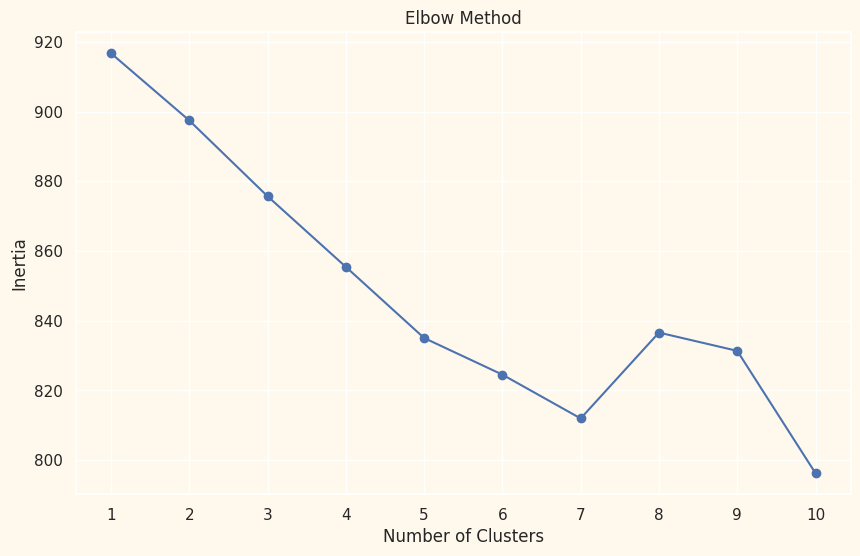

In [148]:
# Determine clusters
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import colors

#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, '-o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()

In [149]:
# k-means clustering
from sklearn.cluster import KMeans

# Choose cluster  =5
num_clusters = 5

# number of clusters
km = KMeans(n_clusters = num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## 4.1. Analyze K-means Result

In [150]:
# create DataFrame films from all of the input files.
product = { 'review': my_list, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])

In [151]:
frame.head(10)

,review,cluster
0,Absolutely love this watch! Get compliments al...,2
1,I love this watch it keeps time wonderfully.,2
2,Scratches,1
3,"It works well on me. However, I found cheaper ...",1
4,Beautiful watch face. The band looks nice all...,1
5,"i love this watch for my purpose, about the pe...",2
6,"for my wife and she loved it, looks great and ...",4
7,I was about to buy this thinking it was a Swis...,1
8,Watch is perfect. Rugged with the metal &#34;B...,4
9,Great quality and build.<br />The motors are r...,1


In [152]:
print ("Number of reviews included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of reviews included in each cluster:


,cluster
1,684
2,87
4,87
3,73
0,68


In [154]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :15]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words_gensim[ind])
        print (tf_selected_words_gensim[ind] + ",", end='')
    print ()

    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews): ")
    print (", ".join(cluster_reviews))
    print ()

<Document clustering result by K-means>
Cluster 0 words:nice,watch,price,simple,really,time,good,looks,looking,strap,light,classy,delivery,love,wife,
Cluster 0 reviews (68 reviews): 
Nice watch, on time delivery from seller., It works well with nice simple look., Wife loves it and nice looking watch,, vary nice, Very nice watch !!!, We looked at many clocks before coming across this one.  It looks very nice runs very smoothly/quietly.  We are very satisfied with this product., nice watch what you see on the picture is what you get, nice but it's a really noisy watch.<br />you will hear it all time... literally every second ..., Very nice watch for running, Nice, Nice, Good Nice watch, Nice desing. I love this watch., Nice, Very nice and reasonably price!, Nice watch, a little complicated getting set up, but has nice features, probably more than I'll ever use. Great looking!, Very nice, the nice watch, Its really nice and it looks good to me. Thumbs up!, Very nice and simple!!!!, Nice w

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [155]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 5)

In [156]:
# document topic matrix for tfidf_matrix_lda
lda_output = lda.fit_transform(tfidf_matrix)
print(lda_output.shape)
print(lda_output)

(999, 5)
[[0.06064703 0.0636645  0.06062583 0.06124419 0.75381845]
 [0.07061222 0.08016315 0.07004292 0.06998951 0.70919221]
 [0.2        0.2        0.2        0.2        0.2       ]
 ...
 [0.08500582 0.08373797 0.0849065  0.08369398 0.66265574]
 [0.10020677 0.10000051 0.10102506 0.10000038 0.59876727]
 [0.06395494 0.06384566 0.06397284 0.06493317 0.74329339]]


In [157]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(5, 244)
[[2.65802866 0.20285485 0.21424991 ... 6.40209465 2.16474327 0.20545948]
 [0.20205055 0.20324377 2.69533401 ... 2.27262127 0.65093013 4.88325223]
 [0.2009302  0.20014128 1.69199175 ... 0.70438068 0.20046899 0.20160447]
 [0.94610706 0.20093975 0.78531059 ... 1.53745615 2.47916365 0.20081912]
 [1.08086698 7.59902549 0.20166074 ... 2.93457154 1.80089238 3.12055104]]


In [158]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(my_list))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,topic
Doc0,0.06,0.06,0.06,0.06,0.75,4
Doc1,0.07,0.08,0.07,0.07,0.71,4
Doc2,0.20,0.20,0.20,0.20,0.20,0
Doc3,0.08,0.08,0.67,0.08,0.08,2
Doc4,0.56,0.04,0.04,0.05,0.31,0
Doc5,0.07,0.08,0.07,0.07,0.71,4
Doc6,0.06,0.23,0.29,0.36,0.06,3
Doc7,0.08,0.08,0.08,0.08,0.69,4
Doc8,0.61,0.04,0.14,0.17,0.04,0
Doc9,0.75,0.06,0.06,0.06,0.06,0


In [159]:
df_document_topic['topic'].value_counts().to_frame()

,topic
0,345
4,209
3,174
2,151
1,120


In [160]:
# topic word matrix
print(lda.components_)
# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)

# column and index
df_topic_words.columns = tfidf_model.get_feature_names_out()
df_topic_words.index = topic_names

df_topic_words.head()

[[2.65802866 0.20285485 0.21424991 ... 6.40209465 2.16474327 0.20545948]
 [0.20205055 0.20324377 2.69533401 ... 2.27262127 0.65093013 4.88325223]
 [0.2009302  0.20014128 1.69199175 ... 0.70438068 0.20046899 0.20160447]
 [0.94610706 0.20093975 0.78531059 ... 1.53745615 2.47916365 0.20081912]
 [1.08086698 7.59902549 0.20166074 ... 2.93457154 1.80089238 3.12055104]]


,able,absolutely,actually,alarm,amazing,amazon,arrived,automatic,awesome,bad,...,wife,wish,work,working,works,worn,worth,wrist,year,years
Topic0,2.658029,0.202855,0.214250,1.215777,8.411932,2.973006,1.008863,4.332156,0.200050,4.248667,...,0.201960,0.228774,4.105367,0.318214,0.205095,1.520841,2.298068,6.402095,2.164743,0.205459
Topic1,0.202051,0.203244,2.695334,0.816294,0.200924,0.203542,0.201883,0.200289,13.374125,4.741813,...,0.201938,0.201186,1.054542,1.728301,0.201788,2.009004,0.969088,2.272621,0.650930,4.883252
Topic2,0.200930,0.200141,1.691992,0.200160,0.203585,0.519296,0.200954,0.200156,0.203525,0.200888,...,0.202498,0.255891,0.201275,0.202007,18.253011,0.200261,0.200779,0.704381,0.200469,0.201604
Topic3,0.946107,0.200940,0.785311,0.200377,0.201529,0.527219,0.200083,0.200254,0.202762,0.203781,...,10.498469,3.468612,5.336561,6.890427,0.202672,0.201603,0.614022,1.537456,2.479164,0.200819
Topic4,1.080867,7.599025,0.201661,2.706967,1.745892,2.753846,5.241596,0.200633,0.201646,0.201320,...,0.569329,0.224978,3.727782,2.178529,2.313562,0.202087,2.817385,2.934572,1.800892,3.120551


In [161]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names_out())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=15)

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,watch,br,beautiful,band,face,time,like,big,expected,large,light,great,looks,little,size
Topic 1,love,like,loved,awesome,gift,watch,pretty,clock,bought,years,bad,month,received,time,date
Topic 2,great,watch,product,works,excellent,price,good,just,looking,fast,stylish,delivery,deal,strap,wanted
Topic 3,nice,watch,loves,got,really,wife,looks,price,look,husband,use,fits,working,simple,heavy
Topic 4,good,watch,perfect,band,time,looks,quality,exactly,beautiful,far,absolutely,picture,love,better,buy
